In [8]:
from datasets import load_dataset
import os
from transformers import AutoFeatureExtractor
import evaluate
import pandas as pd
from transformers import AutoFeatureExtractor
from transformers import AutoModelForAudioClassification
import torch
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
from sklearn.metrics import classification_report

## LOADING DATASET

In [5]:

# Custom filter to ignore _background_noise_
def filter_noise(example):
    return "_background_noise_" not in example["file"]

# Load all .wav files with directory names as labels
dataset = load_dataset(
    "audiofolder",
    data_dir="audio_data/train/audio"
)['train']

# Filter out the background noise folder
dataset = dataset.filter(lambda ex: "_background_noise_" not in ex["audio"]["path"])

labels = dataset.features["label"].names # List of 32 label names (30 normal, silence, and filtered out _background_silence_)
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

def add_label_str(example):
    example["label_str"] = id2label[str(example["label"])]
    return example

dataset = dataset.map(add_label_str)

categories_to_predict = {'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence'}

known_label_ids = {i for i, name in enumerate(labels) if name in categories_to_predict}

def map_labels_str(example):
    label_str = example['label_str']
    if label_str in categories_to_predict:
        return {"label_str": label_str}
    else:
        return {"label_str": "unknown"}

def map_labels(example):
    label = example['label']
    if label in known_label_ids:
        return {"label": label}
    else:
        return {"label": -1} # unknown label

dataset = dataset.map(map_labels_str)
dataset = dataset.map(map_labels)

def load_split_list(txt_path):
    with open(txt_path, "r") as f:
        return [line.strip() for line in f.readlines()]
        
test_list = load_split_list("audio_data/train/testing_list_with_silence_balanced.txt")
val_list = load_split_list("audio_data/train/validation_list_with_silence_balanced.txt")

def get_split(dataset, split_list):
    
    split_set = set(split_list)

    def is_in_split(example):
        return '/'.join(example['audio']['path'].split('/')[-2:]) in split_set

    return dataset.filter(is_in_split)

val_dataset = get_split(dataset, val_list)
test_dataset = get_split(dataset, test_list)

In [7]:
def show_accuracies(val_dataset):

    accuracy = evaluate.load("accuracy")
    confusion_matrix = evaluate.load("confusion_matrix")
    references = val_dataset['label']

    for model_no in range(1,6):
        feature_extractor = AutoFeatureExtractor.from_pretrained(f"wav2vec2_final_model_{model_no}")
        model = AutoModelForAudioClassification.from_pretrained(f"wav2vec2_final_model_{model_no}")

        model.eval()

        predictions = []
        for sample in val_dataset:
            audio_array = sample['audio']['array']
            inputs = feature_extractor(audio_array, sampling_rate=16000, return_tensors="pt")
            with torch.no_grad():
                logits = model(**inputs).logits
            predicted_class_id = torch.argmax(logits).item()
            predictions.append(predicted_class_id)

        print('Accuracy of val set for model {}: {:.3f}'.format(model_no, accuracy.compute(references=references, predictions=predictions)['accuracy']))

show_accuracies(val_dataset)



Accuracy of val set for model 1: 0.897
Accuracy of val set for model 2: 0.891
Accuracy of val set for model 3: 0.899
Accuracy of val set for model 4: 0.901
Accuracy of val set for model 5: 0.090


In [35]:
label2id = {
'unknown': '-1',
'down': '5',
'go': '9',
'left': '12',
'no': '15',
'off': '16',
'on': '17',
'right': '19',
'silence': '22',
'stop': '24',
'up': '28',
'yes': '30'}

id2label = {
'-1': 'unknown',
'5': 'down',
'9': 'go',
'12': 'left',
'15': 'no',
'16': 'off',
'17': 'on',
'19': 'right',
'22': 'silence',
'24': 'stop',
'28': 'up',
'30': 'yes'
}

In [36]:
accuracy = evaluate.load("accuracy")
confusion_matrix = evaluate.load("confusion_matrix")

feature_extractor = AutoFeatureExtractor.from_pretrained(f"wav2vec2_final_model_4")
model = AutoModelForAudioClassification.from_pretrained(f"wav2vec2_final_model_4")

model.eval()

predictions = []
for sample in test_dataset:
    audio_array = sample['audio']['array']
    inputs = feature_extractor(audio_array, sampling_rate=16000, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = torch.argmax(logits).item()
    predictions.append(predicted_class_id)

references = test_dataset['label']


In [37]:
labels = [id2label[str(class_)] for class_ in sorted(list(set(references) | set(predictions)))]

print('Accuracy: {}'.format(accuracy.compute(references=references, predictions=predictions)['accuracy']))


Accuracy: 0.8994673768308922


In [44]:
test_dataset[0]

{'audio': {'path': '/Users/mateuszw/files/transformers_project/audio_data/train/audio/bed/4845bb10_nohash_0.wav',
  'array': array([ 0.00094604,  0.0020752 ,  0.00222778, ..., -0.00158691,
         -0.00228882, -0.0027771 ], shape=(16000,)),
  'sampling_rate': 16000},
 'label': -1,
 'label_str': 'unknown'}

In [45]:
predictions[0]

19


Classification Report:

              precision    recall  f1-score   support

     unknown       0.00      0.00      0.00       237
        down       0.94      0.95      0.95       253
          go       0.95      0.97      0.96       251
        left       0.89      0.98      0.93       267
          no       0.96      0.97      0.96       252
         off       0.95      0.97      0.96       262
          on       0.83      0.98      0.90       246
       right       0.70      0.98      0.82       259
     silence       1.00      1.00      1.00       200
        stop       0.95      0.99      0.97       249
          up       0.88      0.99      0.93       272
         yes       0.95      0.97      0.96       256

    accuracy                           0.90      3004
   macro avg       0.83      0.90      0.86      3004
weighted avg       0.84      0.90      0.86      3004



/Users/mateuszw/files/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mateuszw/files/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mateuszw/files/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

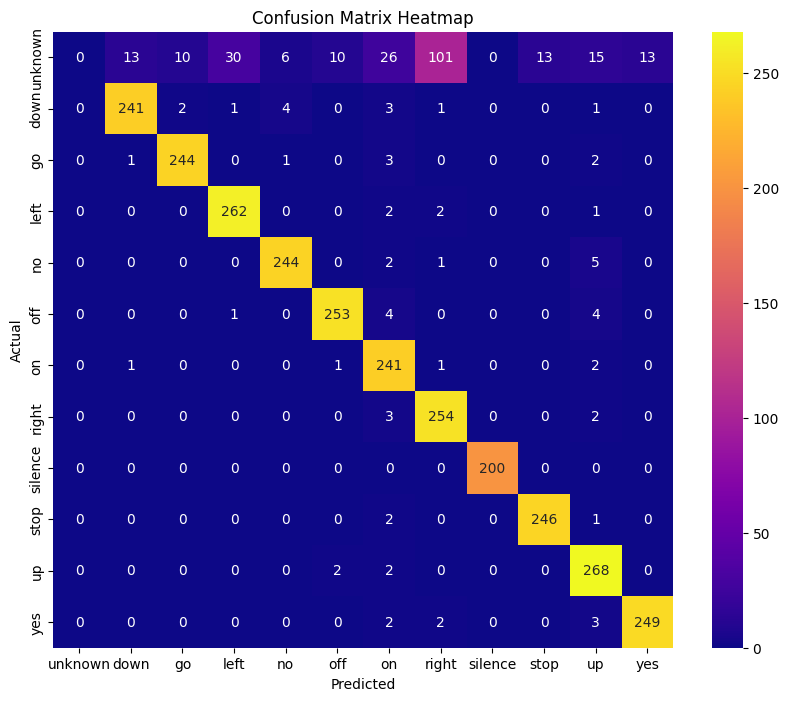

In [ ]:

print("\nClassification Report:\n")
print(classification_report(references, predictions, target_names=labels))

conf_matrix = confusion_matrix.compute(references=references, predictions=predictions)['confusion_matrix']
df_cm = pd.DataFrame(conf_matrix, index=labels, columns=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="plasma") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()



In [ ]:
import pandas as pd

matches = df_cm[(df_cm > 2) & (df_cm < 100)]
result = matches.stack().reset_index()
result.columns = ['real_class', 'predicted_class', 'value']

print(result)
print("Total count:", len(result))

# Tree and Three pair is most problematic


   real_class predicted_class  value
0       eight           three    3.0
1          go           three    4.0
2          no           three    5.0
3          on             off    3.0
4         one           three    4.0
5       right           three    5.0
6         six           three    3.0
7       three            tree    8.0
8        tree           three   16.0
9          up             off    4.0
10         up           three    5.0
11        yes           three    5.0
12       zero          sheila    4.0
Total count: 13
